# Video segmentation with SAM2

SAM2 doesn't seem to handle objects jumping frame with some gap. Although it is flowing in one direction it is unable to propagate the movement of the mask off the shelf if the gap is too big.

## Setup

## Convert image to jpeg for this tutorial

In [ ]:
import os
import glob
from PIL import Image
from tqdm import tqdm

def convert_to_jpeg(input_path, output_path, quality=95):
    with Image.open(input_path) as img:
        # Convert to RGB if needed
        if img.mode != 'RGB':
            img = img.convert('RGB')
        img.save(output_path, 'JPEG', quality=quality)

def convert_video_to_jpeg(video_dir, jpeg_dir, quality=95):
    # Get all image files
    image_files = sorted(glob.glob(os.path.join(video_dir, "*.tiff")))  # Adjust extension if needed
    
    if not image_files:
        raise ValueError(f"No image files found in {video_dir}")
        
    print(f"Found {len(image_files)} images to convert")
    
    # Create output directory if it doesn't exist
    os.makedirs(jpeg_dir, exist_ok=True)
    
    # Convert each image with progress bar
    for idx, image_file in tqdm(enumerate(image_files), total=len(image_files), desc="Converting to JPEG"):
        try:
            output_filename = f"{idx:05d}.jpg"
            output_path = os.path.join(jpeg_dir, output_filename)
            
            convert_to_jpeg(image_file, output_path, quality)
            
        except Exception as e:
            print(f"Error converting {image_file}: {str(e)}")

# Run the conversion
video_dir = "../../data/01_raw/sam2_test/"
jpeg_dir = "../../data/02_intermediate/sam2_test_jpeg/"
convert_video_to_jpeg(video_dir, jpeg_dir)


### Kedro Setup

This notebooks shows how to use SAM 2 for interactive segmentation while using Kedro DatalogIO 

In [ ]:
from kedro.io import DataCatalog
import yaml
import logging

logger = logging.getLogger(__name__)

with open("catalog.yml") as f:
    conf_catalog = yaml.safe_load(f)

catalog = DataCatalog.from_config(conf_catalog)

with open("parameters.yml", encoding="utf-8") as yaml_file:
    params = yaml.safe_load(yaml_file)

kedro_ds = catalog.load("sam2_test")
print(f'len(egrabber_paa6): {len(kedro_ds)}')

### Loading the SAM 2 video predictor from huggingface

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")


In [16]:
from sam2.sam2_video_predictor import SAM2VideoPredictor

predictor = SAM2VideoPredictor.from_pretrained("facebook/sam2-hiera-large")
# predictor = predictor.to(device)

In [17]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

# Inference

### Show image from partitioned dataset loaded from catalog

In [ ]:
# examine partitioned dataset type
print(type(kedro_ds))

# check if egrabber_paa6 is a dictionary
if isinstance(kedro_ds, dict):
    # show the first 5 keys
    print(list(kedro_ds.keys())[:5])

    first_key = next(iter(kedro_ds))
    first_frame_dataset = kedro_ds[first_key]
    
    # load the first frame
    first_frame = first_frame_dataset()
    print("First frame loaded:", first_frame)
else:
    print("egrabber_paa6 is not a dictionary.")

np_first_frame = np.array(first_frame)
# show information about the first frame
print("First frame shape:", np_first_frame.shape)
print("First frame dtype:", np_first_frame.dtype)
# number of channels


# take a look at the first video frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {first_key}")
plt.imshow(first_frame, cmap="gray")

### Path based image access and show

In [ ]:
# `video_dir` a directory of JPEG frames with filenames like `<ds_name>.<frame_index>.jpg`

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(jpeg_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0].split(".")[-1]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(jpeg_dir, frame_names[frame_idx])))

### Initialize the inference state

Current tutorial uses path not kedro partitioned dataset

In [ ]:
inference_state = predictor.init_state(video_path=jpeg_dir)

## Step 1: Add a first clock on a frame

To get started, let's try to segment the child on the left.

Here we make a **positive click** at (x, y) = (680, 175) with label `1`, by sending their coordinates and labels into the `add_new_points_or_box` API.

Note: label `1` indicates a *positive click (to add a region)* while label `0` indicates a *negative click (to remove a region)*.

In [ ]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (210, 350) to get started
points = np.array([[680, 175]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(jpeg_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

## Step 2: Add a second clock to refine the prediction (Optional)

In [ ]:
# ann_frame_idx = 0  # the frame index we interact with
# ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# # Let's add a 2nd positive click at (x, y) = (250, 220) to refine the mask
# # sending all clicks (and their labels) to `add_new_points_or_box`
# points = np.array([[680, 175], [x, y]], dtype=np.float32)
# # for labels, `1` means positive click and `0` means negative click
# labels = np.array([1, 1], np.int32)
# _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
#     inference_state=inference_state,
#     frame_idx=ann_frame_idx,
#     obj_id=ann_obj_id,
#     points=points,
#     labels=labels,
# )

# # show the results on the current (interacted) frame
# plt.figure(figsize=(9, 6))
# plt.title(f"frame {ann_frame_idx}")
# plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
# show_points(points, labels, plt.gca())
# show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

## Step 3: Propagate the prompts to get the masklet across the video

In [ ]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 1
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(jpeg_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

### Step 4: Add new prompts to further refine the masklet

KeyError: 1

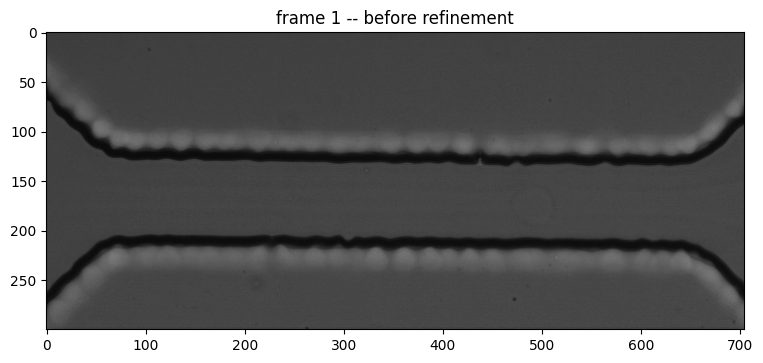

In [28]:
ann_frame_idx = 1  # further refine some details on this frame
ann_obj_id = 1  # give a unique id to the object we interact with (it can be any integers)

# show the segment before further refinement
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx} -- before refinement")
plt.imshow(Image.open(os.path.join(jpeg_dir, frame_names[ann_frame_idx])))
show_mask(video_segments[ann_frame_idx][ann_obj_id], plt.gca(), obj_id=ann_obj_id)

# Let's add a negative click on this frame at (x, y) = (82, 415) to refine the segment
points_f_1 = np.array([[500, 175]], dtype=np.float32)

# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
_, _, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points_f_1,
    labels=labels,
)


# show the segment after the further refinement
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx} -- after refinement")
plt.imshow(Image.open(os.path.join(jpeg_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits > 0.0).cpu().numpy(), plt.gca(), obj_id=ann_obj_id)

#### Step 5: Propagate the prompts (again) to get the masklet across the video

In [ ]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 1
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(jpeg_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

In [65]:
predictor.reset_state(inference_state)